#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Описание данных

Количество заказов находится в столбце ***'num_orders'*** (от англ. number of orders, «число заказов»).

## Подготовка и изучение данных

In [ ]:
import pandas as pd 
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

import warnings 
warnings.simplefilter('ignore')

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверка наличия пропусков в данных:

In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

Проверка упорядоченности датасета:

In [ ]:
print(df.index.is_monotonic)

True


### Вывод:

Данные загружены, не требуют предобработки.

## Анализ

Для анализа данных проведем ресемплирование по часу, неделе и месяцу:

In [ ]:
month_df = df.resample('1M').sum()
week_df = df.resample('1W').sum()
hour_df = df.resample('1H').sum()

Cтатистика заказов в разбивке по месяцам и неделям:

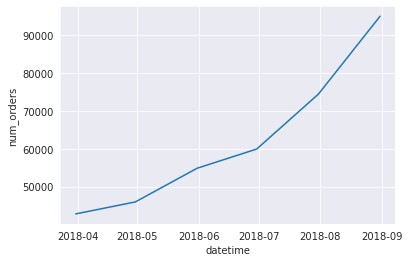

In [ ]:
sns.lineplot(x=month_df.index,y=month_df['num_orders'])
plt.show()

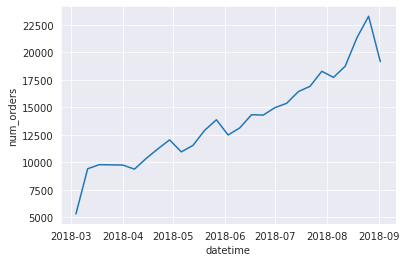

In [ ]:
sns.lineplot(x=week_df.index,y=week_df['num_orders'])
plt.show()

Cкользящее среднее и скользящее стандартное отклонение:

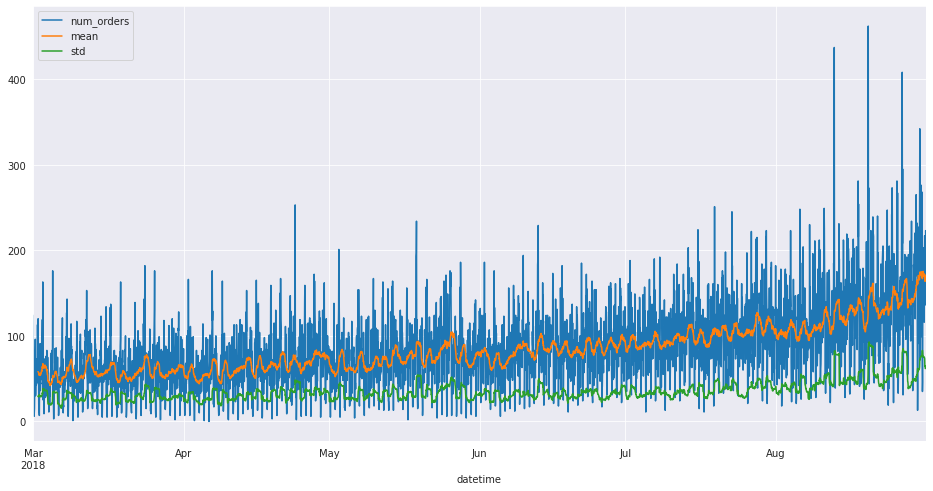

In [ ]:
hour_df['mean'] = hour_df['num_orders'].rolling(25).mean()
hour_df['std'] = hour_df['num_orders'].rolling(25).std()
hour_df.plot(figsize=(16,8))
plt.show()

Для анализа тренда и сезонности ресемплируем датасет по часу:

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


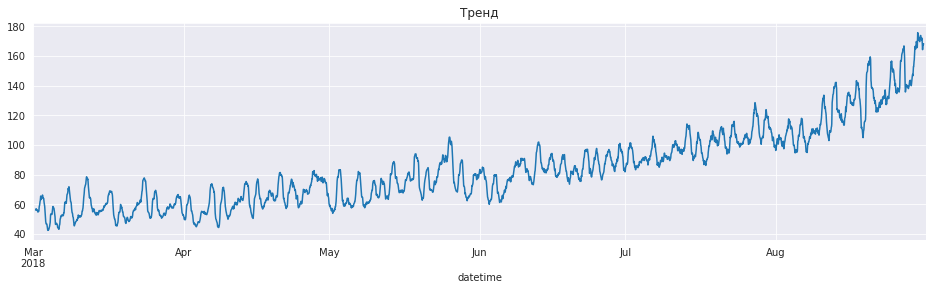

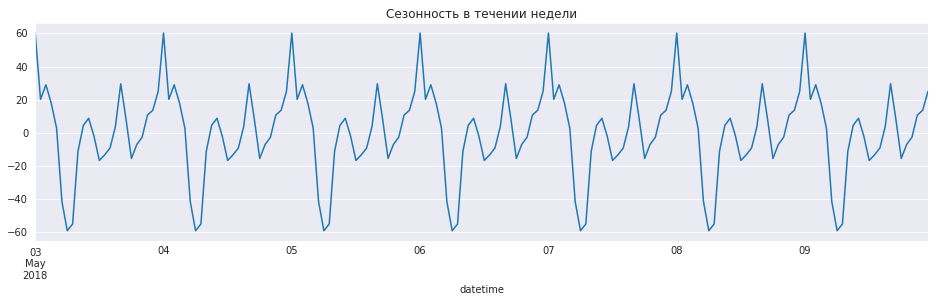

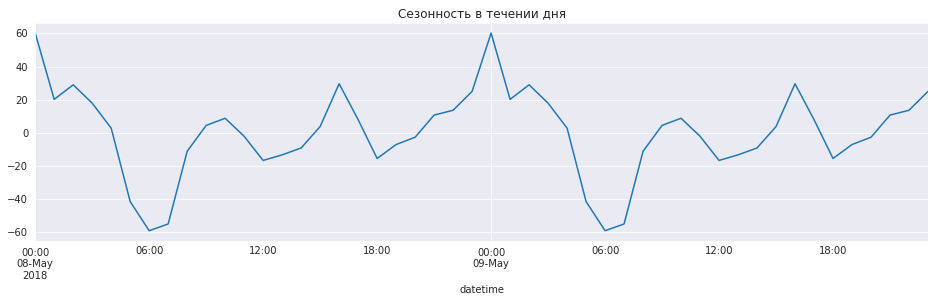

In [ ]:
decomposed_df = seasonal_decompose(df)
decomposed_df.trend.plot(title='Тренд', figsize=(16,4))
plt.show()
decomposed_df.seasonal['2018-05-03':'2018-05-09'].plot(title='Сезонность в течении недели', figsize=(16,4))
plt.show()
decomposed_df.seasonal['2018-05-08':'2018-05-09'].plot(title='Сезонность в течении дня', figsize=(16,4))
plt.show()

### Вывод:

В ходе анализа полученных данных можно сделать следующие выводы:

Имеющиеся данные представляют собой количество заказов такси с марта по август 2018 года в разбиении по 10 минут. В ходе предобработки, данные были ресемплированы по 1 часу.

- Наблюдаем глобальный тренд на увеличение заказов.
- Наблюдаем проявление сезонности ежедневно: больше всего заказов вечером, а меньше всего глубокой ночью.
- Сезонность внутри недели также ярко выражена: количество заказов меняется в течении недели с пиками в пятница-суббота и воскресение-понедельник и минимумом в воскресение;

Для предсказания количества заказов важными будут являться следующие данные: месяц, день недели и час. Необходимо выделить эти параметры как отдельные признаки в обучающей и тестовой выборках.

## Обучение

Прежде чем переходить к обучению моделей, нужно подготовить данные. Для этого создадим функцию ***data_preprocessing***, в которой будут созданы новые признаки, лаги и скользящее среднее. Также датасет будет разбит на обучающую и тестовые выборки, которые будут разбиты на признаки и целевой признак.

In [ ]:
def data_preprocessing(df, lag_max):

    copy_df = pd.DataFrame(df.copy())

    copy_df['month'] = copy_df.index.month
    copy_df['dayofweek'] = copy_df.index.dayofweek
    copy_df['hour'] = copy_df.index.hour
    
    for lag in range(1, lag_max + 1):
        copy_df["lag_{}".format(lag)] = copy_df['num_orders'].shift(lag)
        
    copy_df['rolling_mean'] = copy_df['num_orders'].shift().rolling(10).mean()    
    
    train_df, test_df = train_test_split(copy_df, shuffle=False, test_size=0.1, random_state=2444666666)
    train_df = train_df.dropna()
        
    target_train = train_df['num_orders']
    features_train = train_df.drop('num_orders', axis=1)
    target_test = test_df['num_orders']
    features_test = test_df.drop('num_orders', axis=1)
    
    return features_train, features_test, target_train, target_test

In [ ]:
features_train, features_test, target_train, target_test = data_preprocessing(df, lag_max=10)

In [ ]:
features_train.head()

,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,3,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,3,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,3,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,3,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


In [ ]:
target_test.head()

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
Freq: H, Name: num_orders, dtype: int64

In [ ]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3964 объектов, 14 признаков
Размер тестовой выборки: 442 объектов, 14 признаков


### Dummy модель

In [ ]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
dummy_predicted = dummy_model.predict(features_train)
rmse_dummy = mean_squared_error(target_train, dummy_predicted)**0.5

print('DummyRegressor RMSE:', rmse_dummy)

DummyRegressor RMSE: 38.65283939410698


### Линейная регрессия

In [ ]:
parametrs = {'normalize' : [True, False]}   
cv = TimeSeriesSplit(n_splits=5)

linear_regression_model = LinearRegression(n_jobs=-1)
grid_linear_regression_model = GridSearchCV(estimator=linear_regression_model, param_grid=parametrs, cv=cv, scoring='neg_mean_squared_error')
grid_linear_regression_model.fit(features_train, target_train)

mse_lr = grid_linear_regression_model.best_score_*(-1)
rmse_lr = mse_lr**0.5
print(grid_linear_regression_model.best_params_)
print('LinearRegression RMSE:', rmse_lr)

{'normalize': False}
LinearRegression RMSE: 31.958550516329094


### LightGBM

In [ ]:
# parametrs = {'max_depth': range(1, 21, 2), 'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': range(1, 502, 100)}         
# cv = TimeSeriesSplit(n_splits=5)

# lgb_model = LGBMRegressor(random_state=244466666)
# grid_lgb = GridSearchCV(estimator=lgb_model, cv=cv, param_grid=parametrs, scoring='neg_mean_squared_error')
# grid_lgb.fit(features_train, target_train)

# mse_lgb = grid_lgb.best_score_*(-1)
# rmse_lgb = mse_lgb**0.5
# print(grid_lgb.best_params_)
# print('LightGBM RMSE:', rmse_lgb)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 501}

LightGBM RMSE: 25.964657468947333

### CatBoost

In [ ]:
# parametrs = {'iterations': range(1, 502, 100), 'learning_rate': [0.1, 0.2, 0.3, 0.4], 'depth': range(1, 21, 2)}
# cv = TimeSeriesSplit(n_splits=5) 

# cbr_model = CatBoostRegressor()
# grid_cbr = GridSearchCV(estimator=cbr_model, param_grid=parametrs, cv=cv, scoring='neg_mean_squared_error')
# grid_cbr.fit(features_train, target_train)

# mse_cbr = grid_cbr.best_score_*(-1)
# rmse_cbr = mse_cbr**0.5
# print(grid_cbr.best_params_)
# print('CatBoost RMSE:', rmse_cbr)

{'depth': 7, 'iterations': 501, 'learning_rate': 0.2}

CatBoost RMSE: 25.647510937817955

### Результат по итогам обучения

In [ ]:
intermediate_result = pd.DataFrame([[rmse_dummy],[rmse_lr],[25.964657468947333],[25.647510937817955]],
                           columns = ['rmse'],
                           index = ['DummyRegressor','LinearRegression','LGBMRegressor','CatBoostRegressor'])
intermediate_result

,rmse
DummyRegressor,38.652839
LinearRegression,31.958551
LGBMRegressor,25.964657
CatBoostRegressor,25.647511


## Тестирование

Найдем значения метрики RMSE для каждой из моделей и для наглядности построим графики сравнения предсказанных и реальных значений числа заказов такси.

### Линейная регрессия

In [ ]:
best_lr_model = LinearRegression(normalize=True)
best_lr_model.fit(features_train, target_train)
lr_predicted = best_lr_model.predict(features_test)
rmse_lr = mean_squared_error(target_test, lr_predicted) ** 0.5
print(f'LinearRegression RMSE: {rmse_lr:.4f}')       

LinearRegression RMSE: 54.1541


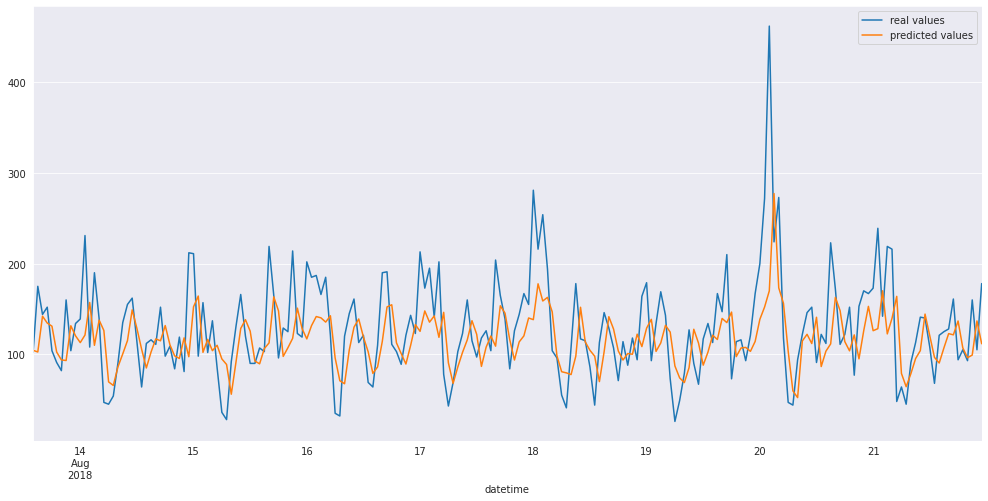

In [ ]:
lr_predicted_series = pd.Series(lr_predicted, index=target_test.index)
plt.figure(figsize=(17,8))
target_test['2018-07-20':'2018-08-21'].plot(legend=True, label='real values')
lr_predicted_series['2018-07-20':'2018-08-21'].plot(legend=True, label='predicted values')
plt.show()

### LightGBM

In [ ]:
best_lgbm_model = LGBMRegressor(learning_rate=0.2, max_depth=7, n_estimators=501, random_state=244466666)
best_lgbm_model.fit(features_train, target_train)
lgbm_predicted = best_lgbm_model.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, lgbm_predicted) ** 0.5
print(f'LGBMRegressor RMSE: {rmse_lgbm:.4f}') 

LGBMRegressor RMSE: 44.6949


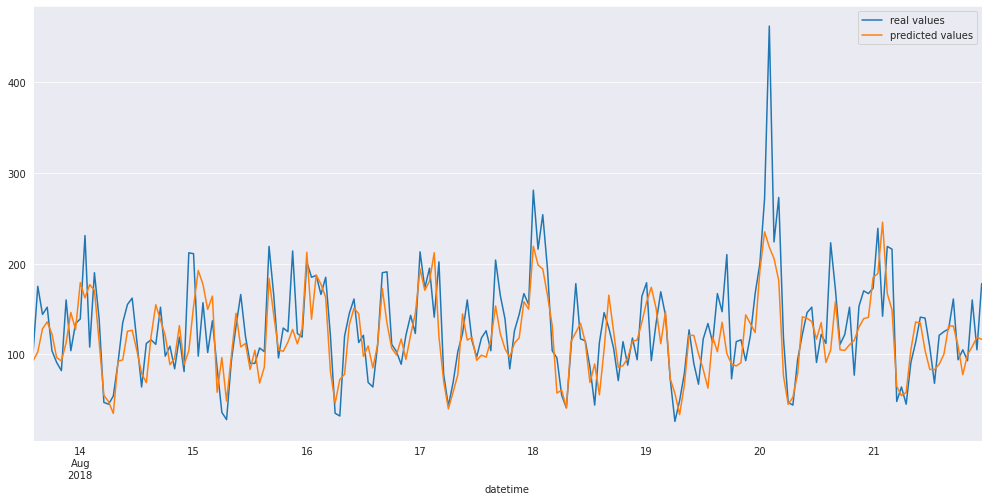

In [ ]:
lgbm_predicted_series = pd.Series(lgbm_predicted, index=target_test.index)
plt.figure(figsize=(17,8))
target_test['2018-07-20':'2018-08-21'].plot(legend=True, label='real values')
lgbm_predicted_series['2018-07-20':'2018-08-21'].plot(legend=True, label='predicted values')
plt.show()

### CatBoost

In [ ]:
best_cbr_model = CatBoostRegressor(depth=7, iterations=501, learning_rate=0.2, verbose=0)
best_cbr_model.fit(features_train, target_train)
cbr_predicted = best_cbr_model.predict(features_test)
rmse_cbr = mean_squared_error(target_test, cbr_predicted) ** 0.5
print(f'RandomForestRegressor RMSE: {rmse_cbr:.4f}')

RandomForestRegressor RMSE: 44.2442


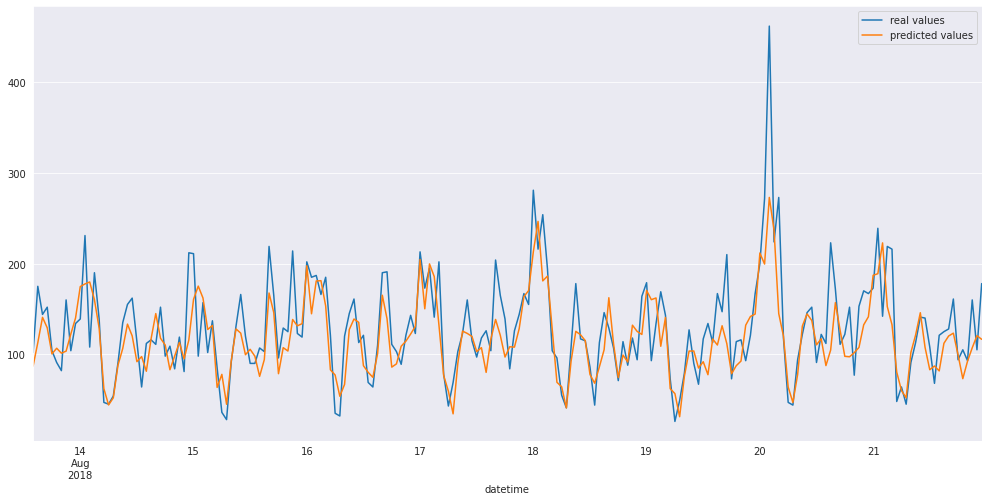

In [ ]:
cbr_predicted_series = pd.Series(cbr_predicted, index=target_test.index)
plt.figure(figsize=(17,8))
target_test['2018-07-20':'2018-08-21'].plot(legend=True, label='real values')
cbr_predicted_series['2018-07-20':'2018-08-21'].plot(legend=True, label='predicted values')
plt.show()

### Финальный результат

In [ ]:
final_result = pd.DataFrame([[rmse_lr],[rmse_lgbm],[rmse_cbr]], columns = ['rmse_test'],
                           index = ['LinearRegression','LGBMRegressor','CatBoostRegressor'])
final_result

,rmse_test
LinearRegression,54.154128
LGBMRegressor,44.694858
CatBoostRegressor,44.244213


## Вывод

Целью данной работы было получить модель, предсказывающую количество заказов такси на следующий час. Для предсказаний были выбраны модели линейной регрессии и градиентного бустинга. Результаты оценивались метрикой RMSE, в результате тестирования ошибка двух моделей оказалась лучше требуемой заказчиком - это модели LightGBM и CatBoost.

Лучшей моделью на тестовой выборке оказалась CatBoost модель. Полученный результат RMSE равен 44.244. Результаты исследований можно применять для дальнейшей разработки предсказательной модели и внедрения в бизнес процесс.